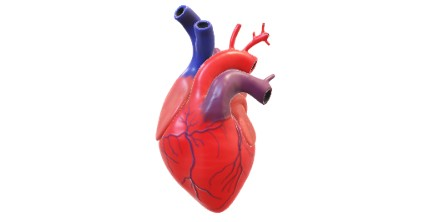
# Heart Disease Prediction

  **Data Prepared**

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report



In [2]:
# Start a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("heart disease").getOrCreate()

In [3]:
# Read in data
from pyspark import SparkFiles
url = 'https://raw.githubusercontent.com/cwa312/Project4/refs/heads/main/Resources/heart.csv'
spark.sparkContext.addFile(url)
spark_df = spark.read.csv(SparkFiles.get("heart.csv"), sep=",", header=True,inferSchema=True)

# Show DataFrame
spark_df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [4]:
# print schemas
spark_df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)



In [5]:
# convert the spark_df into pandas
df=spark_df.toPandas()

# display the data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## our target:
1 means positive or *Precsence*  0 means negative or Abscence





# **description**



* cp = chestpain
* trestbps=resting blood pressure
* chol =serum cholestoral
* fbs= fasting blood sugar > 120 mg/dl
* thalach=maximum heart rate achieved
* exang =exercise induced angina
* oldpeak=ST depression induced by exercise relative to rest
* restecg=Resting electrocardiographic results
* ca =number of major vessels colored by fluoroscopy
* thal =thalium stress test result
* target presence of heart disease
* slope = slope of the peak excercise st segment




 **Data preprocessing**

In [6]:
# display the summary of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int32  
 1   sex       303 non-null    int32  
 2   cp        303 non-null    int32  
 3   trestbps  303 non-null    int32  
 4   chol      303 non-null    int32  
 5   fbs       303 non-null    int32  
 6   restecg   303 non-null    int32  
 7   thalach   303 non-null    int32  
 8   exang     303 non-null    int32  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int32  
 11  ca        303 non-null    int32  
 12  thal      303 non-null    int32  
 13  target    303 non-null    int32  
dtypes: float64(1), int32(13)
memory usage: 17.9 KB


In [7]:
# define the continous feature(Numercal feature)
numerical_feature=["age","trestbps","chol","fbs","thalach","oldpeak","target"]

In [8]:
# identify the categorical variable using list comperhensive
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
df[categorical_feature]= df[categorical_feature].astype('object')

In [9]:
# check the dtypes after it is converted
df.dtypes

,0
age,int32
sex,object
cp,object
trestbps,int32
chol,int32
fbs,int32
restecg,object
thalach,int32
exang,object
oldpeak,float64


**Explore data**

In [10]:
# get the summary statistics for numerical variable
df[numerical_feature].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
trestbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
thalach,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2
target,303.0,0.544554,0.498835,0.0,0.0,1.0,1.0,1.0


In [11]:
# get the summary statistics for categorical variable
df[categorical_feature].describe().T

,count,unique,top,freq
sex,303,2,1,207
cp,303,4,0,143
restecg,303,3,1,152
exang,303,2,0,204
slope,303,3,2,142
ca,303,5,0,175
thal,303,4,2,166


In [12]:
# check for missing value in the dataset
df.isnull().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


**Plot the distirbution of numerical features**

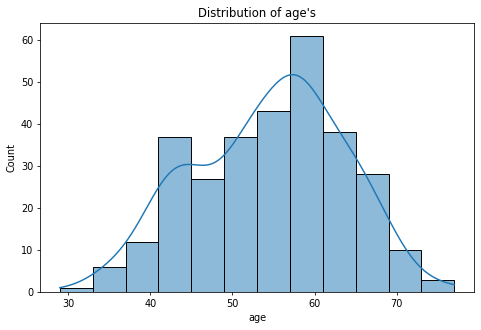

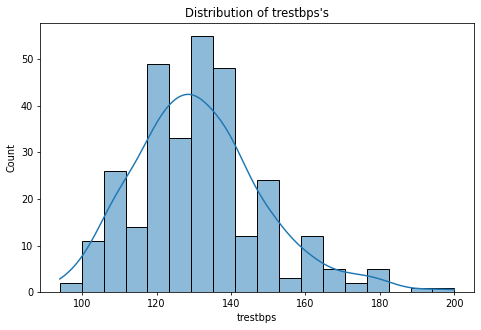

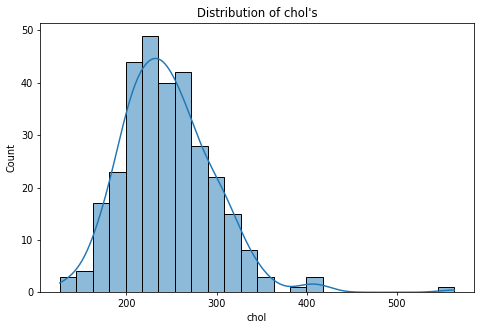

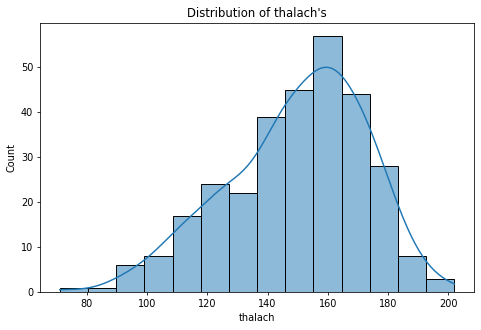

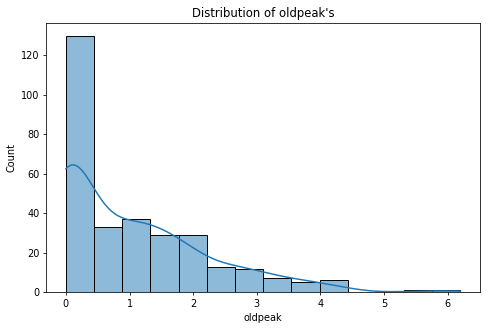

In [13]:

# plot the distribution of the dataset on numerical value
feature_to_plot=["age","trestbps","chol","thalach","oldpeak"]
#plt.subplots(figsize=(12,7),dpi=70)
for index,feature in enumerate(feature_to_plot):
  plt.subplots(figsize=(8,5),dpi=70)
  sns.histplot(data=df[feature],kde=True)

  plt.title(f"Distribution of {feature}'s")



*   most of our data is evenly distributed
*   oldpeak or ST depression induced by exercise relative to rest is centered to zero



In [14]:
# check outlier for the numerical variable
q1=df[feature_to_plot].quantile(.25)
q3=df[feature_to_plot].quantile(.75)
IQR=q3-q1
lower_bound=q1-1.5*IQR
upper_bound =q3+1.5*IQR
out_lier_count =(df[feature_to_plot]<lower_bound) | (df[feature_to_plot]>upper_bound)
out_lier_count.sum()

,0
age,0
trestbps,9
chol,5
thalach,1
oldpeak,5


In [15]:
# encode the categorical variable using get_dummies()

cat_encode =pd.get_dummies(df[categorical_feature],dtype=int)
cat_encode

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,exang_0,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,0,1,0,0,0,1,1,0,0,1,...,0,1,0,0,0,0,0,1,0,0
1,0,1,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,1,0,0,1,0,0,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,0,1,0,1,0,0,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,1,0,1,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,0,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
299,0,1,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1
300,0,1,1,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
301,0,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [16]:
# concate the categorical and numerical variable and target
concate_df=pd.concat([cat_encode,df[numerical_feature]],axis=1)
concate_df.head()

,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,exang_0,...,thal_1,thal_2,thal_3,age,trestbps,chol,fbs,thalach,oldpeak,target
0,0,1,0,0,0,1,1,0,0,1,...,1,0,0,63,145,233,1,150,2.3,1
1,0,1,0,0,1,0,0,1,0,1,...,0,1,0,37,130,250,0,187,3.5,1
2,1,0,0,1,0,0,1,0,0,1,...,0,1,0,41,130,204,0,172,1.4,1
3,0,1,0,1,0,0,0,1,0,1,...,0,1,0,56,120,236,0,178,0.8,1
4,1,0,1,0,0,0,0,1,0,0,...,0,1,0,57,120,354,0,163,0.6,1


our target_variable is target

In [17]:
# Split our preprocessed data into our features and target arrays
y=concate_df['target'].values
x=concate_df.drop(columns=['target']).values

**Scale and transform the dataset**

**Split the Data into train and test datasets**

In [18]:
# # Splitting data into train and test sets
x_train,x_test,y_train,y_test =train_test_split(x,y,random_state=0,stratify=y)

# create standardScaler instance
scaler=StandardScaler()
# fit the train data to the scaler
x_scaler =scaler.fit(x_train)
# transform the data
x_train_scaled =x_scaler.transform(x_train)
x_test_scaled=x_scaler.transform(x_test)

# KNN Model

In [19]:


# Define the model
knn = KNeighborsClassifier()

# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(knn, param_grid, cv=5, refit=True, verbose=2,scoring='recall',n_jobs=-1)
grid_search.fit(x_train_scaled, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on test data
best_knn = grid_search.best_estimator_
knn_pred =best_knn.predict(x_test_scaled)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best Score: 0.8949999999999999


 Check for overfitting

In [20]:
# print the classification report for the test
print(classification_report(y_test,knn_pred,target_names=["KNN_Absence","KNN_Presence"]))

              precision    recall  f1-score   support

 KNN_Absence       0.84      0.77      0.81        35
KNN_Presence       0.82      0.88      0.85        41

    accuracy                           0.83        76
   macro avg       0.83      0.82      0.83        76
weighted avg       0.83      0.83      0.83        76



In [21]:
# print classification report for the train dataset
print(classification_report(y_train,best_knn.predict(x_train_scaled),target_names=["Absence","Presence"]))

              precision    recall  f1-score   support

     Absence       0.90      0.80      0.85       103
    Presence       0.85      0.93      0.88       124

    accuracy                           0.87       227
   macro avg       0.87      0.86      0.86       227
weighted avg       0.87      0.87      0.87       227



#Note:
the data is not  overfitted as we see that the recall on both train and test are not big different.

#pattern:
for example 88% recall on test and 93% recall on train  model predicted .

the model identified 88% of the heart disease.

In [22]:
# Pass the variable on the test clssfication report
out_put=classification_report(y_test,best_knn.predict(x_test_scaled),output_dict=True,target_names=["KNN_Absence","KNN_Presence"])
out_put

{'KNN_Absence': {'precision': 0.84375,
  'recall': 0.7714285714285715,
  'f1-score': 0.8059701492537313,
  'support': 35.0},
 'KNN_Presence': {'precision': 0.8181818181818182,
  'recall': 0.8780487804878049,
  'f1-score': 0.8470588235294118,
  'support': 41.0},
 'accuracy': 0.8289473684210527,
 'macro avg': {'precision': 0.8309659090909092,
  'recall': 0.8247386759581882,
  'f1-score': 0.8265144863915715,
  'support': 76.0},
 'weighted avg': {'precision': 0.8299566387559809,
  'recall': 0.8289473684210527,
  'f1-score': 0.828136407744559,
  'support': 76.0}}

In [34]:
# convert to dataframe
KNN_report_df = pd.DataFrame(out_put).transpose().round(2)
KNN_report_df

,precision,recall,f1-score,support
KNN_Absence,0.84,0.77,0.81,35.00
KNN_Presence,0.82,0.88,0.85,41.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.83,0.82,0.83,76.00
weighted avg,0.83,0.83,0.83,76.00


In [35]:
# filter the only recall that have positive result
knn_recall = KNN_report_df[KNN_report_df.index=='KNN_Presence']
knn_recall

,precision,recall,f1-score,support
KNN_Presence,0.82,0.88,0.85,41.0


# SVM Model

In [25]:

# Define SVM model
svm_model = SVC()

# Define the parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']}

In [26]:
# Create a GridSearchCV object
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5,refit=True,verbose=2, n_jobs=-1)
svm_grid_search.fit(x_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             verbose=2)

In [27]:
# Get the best parameters
print("Best Parameters:", svm_grid_search.best_params_)


Best Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}


In [28]:
# make prediction on test dataset
best_svm = svm_grid_search.best_estimator_

check for overfitting by printing classification report on both train and test and check the difference on recall

In [30]:
# print classification report on test dataset
y_test_pred = best_svm.predict(x_test_scaled)
print("=== Classification Report: Test Dataset ===")
print(classification_report(y_test, y_test_pred))

=== Classification Report: Test Dataset ===
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        35
           1       0.85      0.95      0.90        41

    accuracy                           0.88        76
   macro avg       0.89      0.88      0.88        76
weighted avg       0.89      0.88      0.88        76



In [31]:
# print classification report on train dataset.
y_train_pred = best_svm.predict(x_train_scaled)
print("=== Classification Report: Train Dataset ===")
print(classification_report(y_train, y_train_pred))

=== Classification Report: Train Dataset ===
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       103
           1       0.83      0.92      0.87       124

    accuracy                           0.85       227
   macro avg       0.86      0.85      0.85       227
weighted avg       0.86      0.85      0.85       227



In [32]:
# convert the test classification report to dictionary
test_report_dict = classification_report(y_test, y_test_pred, output_dict=True,target_names=["SVM_Absence","SVM_Presence"])
test_report_dict

{'SVM_Absence': {'precision': 0.9333333333333333,
  'recall': 0.8,
  'f1-score': 0.8615384615384616,
  'support': 35.0},
 'SVM_Presence': {'precision': 0.8478260869565217,
  'recall': 0.9512195121951219,
  'f1-score': 0.896551724137931,
  'support': 41.0},
 'accuracy': 0.881578947368421,
 'macro avg': {'precision': 0.8905797101449275,
  'recall': 0.875609756097561,
  'f1-score': 0.8790450928381963,
  'support': 76.0},
 'weighted avg': {'precision': 0.8872044241037377,
  'recall': 0.881578947368421,
  'f1-score': 0.8804271953092281,
  'support': 76.0}}

In [33]:
# convert the test classification report to dataframe
test_report_df = pd.DataFrame(test_report_dict).transpose().round(2)
test_report_df

,precision,recall,f1-score,support
SVM_Absence,0.93,0.80,0.86,35.00
SVM_Presence,0.85,0.95,0.90,41.00
accuracy,0.88,0.88,0.88,0.88
macro avg,0.89,0.88,0.88,76.00
weighted avg,0.89,0.88,0.88,76.00


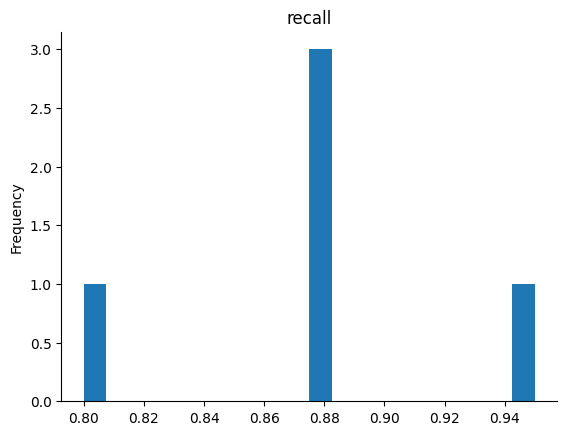

In [36]:
# @title Recall

from matplotlib import pyplot as plt
test_report_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

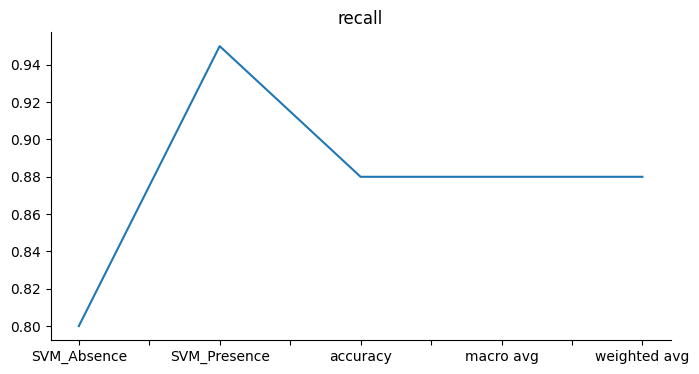

In [37]:
# @title Recall

from matplotlib import pyplot as plt
test_report_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

In [38]:
# filter out the positive result from datafram

svm_recall =test_report_df[test_report_df.index=="SVM_Presence"]


# Display filtered results
svm_recall

,precision,recall,f1-score,support
SVM_Presence,0.85,0.95,0.9,41.0


#Random Forest

In [39]:
# Define the parameter grid for Random Forest
rf_model = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of x_train: (227, 29)
Shape of y_train: (227,)


In [40]:
# fit the train data to the model
grid_search_rf = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1)
grid_search_rf.fit(x_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='recall', verbose=2)

In [41]:
# Get the best parameters
best_rf = grid_search_rf.best_estimator_

# Print the best parameters
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)


Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


In [42]:
# Make predictions using the best model
y_test_pred_rf = best_rf.predict(x_test)

In [43]:
# convert the classification report to dictionary out put
rf_report_dict = classification_report(y_test, y_test_pred_rf, output_dict=True,target_names=["RF_Absence","RF_Presence"])
rf_report_dict

{'RF_Absence': {'precision': 0.8285714285714286,
  'recall': 0.8285714285714286,
  'f1-score': 0.8285714285714286,
  'support': 35.0},
 'RF_Presence': {'precision': 0.8536585365853658,
  'recall': 0.8536585365853658,
  'f1-score': 0.8536585365853658,
  'support': 41.0},
 'accuracy': 0.8421052631578947,
 'macro avg': {'precision': 0.8411149825783972,
  'recall': 0.8411149825783972,
  'f1-score': 0.8411149825783972,
  'support': 76.0},
 'weighted avg': {'precision': 0.8421052631578947,
  'recall': 0.8421052631578947,
  'f1-score': 0.8421052631578947,
  'support': 76.0}}

In [44]:
# conver the dictionary out put to dataframe
rf_report_df = pd.DataFrame(rf_report_dict).transpose().round(2)
rf_report_df


,precision,recall,f1-score,support
RF_Absence,0.83,0.83,0.83,35.00
RF_Presence,0.85,0.85,0.85,41.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.84,0.84,0.84,76.00
weighted avg,0.84,0.84,0.84,76.00


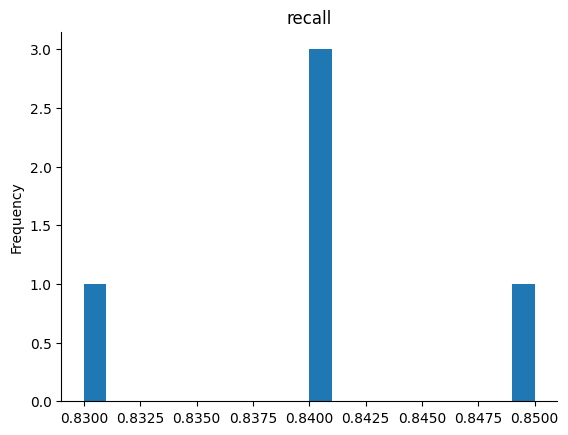

In [45]:
# @title Recall

from matplotlib import pyplot as plt
rf_report_df['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

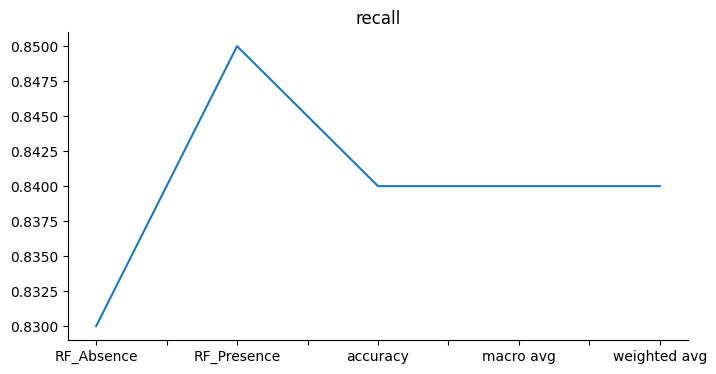

In [46]:
# @title Recall

from matplotlib import pyplot as plt
rf_report_df['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

In [47]:
# filter out only the recal with positive value.
rf_recall = rf_report_df[rf_report_df.index=="RF_Presence"]

# Display the recall value
rf_recall

,precision,recall,f1-score,support
RF_Presence,0.85,0.85,0.85,41.0


**DT MODEL**

In [48]:
# Define the parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [49]:


# Create a GridSearchCV object
dt_grid_search = GridSearchCV(DecisionTreeClassifier(), dt_param_grid, refit=True, verbose=2, cv=5,n_jobs=-1)


In [50]:
# print best param
dt_grid_search.fit(x_train,y_train)
dt_best_param=dt_grid_search.best_params_
print(f'best params:\n{dt_best_param}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best params:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [51]:
# make prediction on DT
dt_pred = dt_grid_search.predict(x_test)

In [52]:
# print classification reports on testing dataset

print(classification_report(y_test,dt_pred,target_names=["DT_Absences","DT_Presences"]))

              precision    recall  f1-score   support

 DT_Absences       0.72      0.74      0.73        35
DT_Presences       0.78      0.76      0.77        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



In [53]:
# convert the classification report to dictionary out put.
dt_dict=classification_report(y_test,dt_pred,target_names=["DT_Absences","DT_Presences"],output_dict=True)

In [55]:
# convert  the dictionary out put  in to dataframe:
dt_df=pd.DataFrame(dt_dict).transpose().round(2)
dt_df

,precision,recall,f1-score,support
DT_Absences,0.72,0.74,0.73,35.00
DT_Presences,0.78,0.76,0.77,41.00
accuracy,0.75,0.75,0.75,0.75
macro avg,0.75,0.75,0.75,76.00
weighted avg,0.75,0.75,0.75,76.00


In [57]:
# filter only the Recall value(positive value)
dt_recall=dt_df[dt_df.index=="DT_Presences"]
dt_recall

,precision,recall,f1-score,support
DT_Presences,0.78,0.76,0.77,41.0


**LogisticRegression**

In [58]:
# Define the parameter grid for Logistic Regression
lr_param_grid = {
    'C': [0.1, 1, 10, 100],              # Regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'solver': ['liblinear', 'saga','lbfgs']      # Solver for optimization
}

In [59]:
# Create a GridSearchCV object
lr_grid_search = GridSearchCV(LogisticRegression(max_iter=10000), lr_param_grid, refit=True, verbose=2, cv=5,n_jobs=-1)

In [61]:
# Perform Grid Search and fit the model
lr_grid_search.fit(x_train_scaled,y_train)
# print the best parameter
print(lr_grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [63]:
# make prediction
lr_pred=lr_grid_search.predict(x_test_scaled)

In [71]:
# print classification report
print(classification_report(y_test,lr_pred,target_names=["LogisticRegresion_Absence","LogisticRegression_Presences"]))


                              precision    recall  f1-score   support

   LogisticRegresion_Absence       0.82      0.80      0.81        35
LogisticRegression_Presences       0.83      0.85      0.84        41

                    accuracy                           0.83        76
                   macro avg       0.83      0.83      0.83        76
                weighted avg       0.83      0.83      0.83        76



In [72]:
#convert the classification report to dictionary
lr_dict=classification_report(y_test,lr_pred,target_names=["LogisticRegresion_Absence","LogisticRegression_Presences"],output_dict=True)
lr_dict

{'LogisticRegresion_Absence': {'precision': 0.8235294117647058,
  'recall': 0.8,
  'f1-score': 0.8115942028985508,
  'support': 35.0},
 'LogisticRegression_Presences': {'precision': 0.8333333333333334,
  'recall': 0.8536585365853658,
  'f1-score': 0.8433734939759037,
  'support': 41.0},
 'accuracy': 0.8289473684210527,
 'macro avg': {'precision': 0.8284313725490196,
  'recall': 0.826829268292683,
  'f1-score': 0.8274838484372272,
  'support': 76.0},
 'weighted avg': {'precision': 0.8288183694530444,
  'recall': 0.8289473684210527,
  'f1-score': 0.828738294137649,
  'support': 76.0}}

In [73]:
# convert the classification report  to DataFrame
lr_df = pd.DataFrame(lr_dict).transpose()

In [75]:
# filter out the true positive
lr_recall=lr_df[lr_df.index=="LogisticRegression_Presences"]
lr_recall

,precision,recall,f1-score,support
LogisticRegression_Presences,0.833333,0.853659,0.843373,41.0



**NeuralNetwork**

Compile, Train and Evaluate the Model

In [77]:
# Set the random seed for reproducibility
import random
random_state = 42
tf.random.set_seed(random_state)
np.random.seed(random_state)
random.seed(random_state)

In [78]:
len(x_train_scaled[0])

29

In [79]:
# define the model
model = tf.keras.models.Sequential()

In [80]:
# First hidden layer
model.add(tf.keras.layers.Dense(units=16,activation='relu',input_dim=len(x_train_scaled[0])))

# second layer
model.add(tf.keras.layers.Dense(units=8,activation='relu'))

In [81]:
# out put layer
model.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

In [82]:
# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 625 (2.44 KB)

 Trainable params: 625 (2.44 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['recall'])

In [84]:
# train the model
model.fit(x_train_scaled,y_train,epochs=50)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6859 - recall: 0.5335
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6437 - recall: 0.6425  
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6123 - recall: 0.7047 
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5850 - recall: 0.7850 
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5611 - recall: 0.7994
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5395 - recall: 0.8295
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5188 - recall: 0.8218  
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4986 - recall: 0.8218 
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4787 - recall: 0.8472 
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4591 - recall: 0.8499 
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4405 - recall: 0.8550 
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4228 - recall: 0.8578 
Epoch 13/50
8/8 ━━━━━━━━

**Check for over fitting**

In [92]:
# evaluate the model on test data
model_loss,Model_recall=model.evaluate(x_test_scaled,y_test,verbose=2)
print(Model_recall)

3/3 - 0s - 16ms/step - loss: 0.5045 - recall: 0.8537
0.8536585569381714


In [93]:
#Evaluate the model on trained data
model_loss_train,Model_recall_train=model.evaluate(x_train_scaled,y_train,verbose=2)

8/8 - 0s - 7ms/step - loss: 0.1967 - recall: 0.9677


**as we see the difference on both test and train are not significantly diffferent**

In [86]:
keras_dict={ "Neural Recall":
                {"recall":Model_recall }}


In [88]:
keras_recall=pd.DataFrame(keras_dict).transpose().round(2)
keras_recall

,recall
Neural Recall,0.85


**Plot all the recall value for all model for comparisons**



---





In [95]:
result_df=pd.concat([knn_recall,svm_recall,rf_recall,dt_recall,lr_recall,keras_recall]).round(2)
result_df

,precision,recall,f1-score,support
KNN_Presence,0.82,0.88,0.85,41.0
SVM_Presence,0.85,0.95,0.90,41.0
RF_Presence,0.85,0.85,0.85,41.0
DT_Presences,0.78,0.76,0.77,41.0
LogisticRegression_Presences,0.83,0.85,0.84,41.0
Neural Recall,NaN,0.85,NaN,NaN


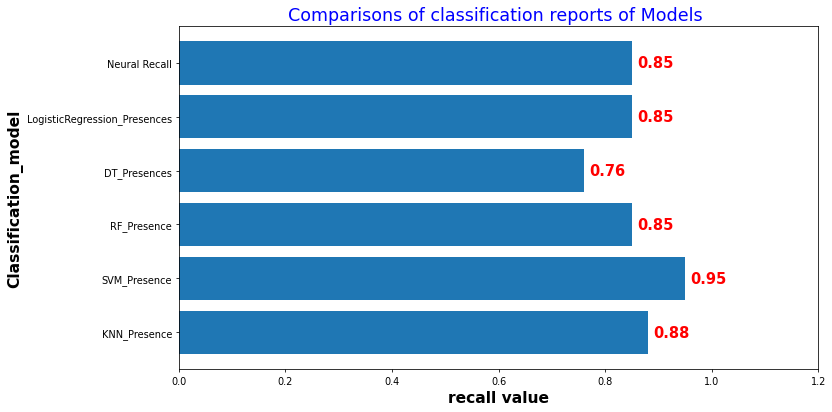

In [100]:
fig,ax=plt.subplots(figsize=(12,6),dpi=70)
ax.barh(result_df.index,result_df['recall'])

for i, result in result_df.iterrows():


  ax.text(result['recall'] + 0.01, i,
          result['recall'],
            ha='left', va='center',
            fontweight='bold', color='red', fontsize=15)


plt.title("Comparisons of classification reports of Models ",color='blue',size = 18)
plt.xlim(0,1.20)
plt.xlabel("recall value",fontweight='bold',size=16)
plt.ylabel("Classification_model",fontweight='bold',size=16)
plt.tight_layout()

plt.show()